# SN 2022hrs for image subtraction

In [1]:
import os,sys
import importlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patches as patches
import pandas as pd
import seaborn as sns
from scipy import signal
#---PythonPhot---#
from PythonPhot import rdpsf
#---my modules---#
import mkpsf_func
import tomoeutils
from run_hotpants import runhotpants

%config InlineBackend.figure_formats = {'png', 'retina'}

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

## SN 2022hrs

In [4]:
# FITS path
fits_dir = '/home/arima/tomoe/tomoeflash/imsub/test/fits/sn2022hrs/'
fits_sci = fits_dir + 'sTMQ2202205190076632115.fits'
fits_ref = fits_dir + 'temp_tg_0305.0280_remap.fits'
# Basename
fits_sci_basename = os.path.splitext(os.path.basename(fits_sci))[0]

# Output directory
out_dir = '/home/arima/tomoe/tomoeflash/imsub/test/diff_fits/sn2022hrs'

In [5]:
print(fits_sci_basename)

sTMQ2202205190076632115


In [7]:
# Open FITS file
header_sci, data_sci = tomoeutils.openfits(fits_sci)
header_ref, data_ref = tomoeutils.openfits(fits_ref)

# Bkg subtraction
data_sci_bkgsub =tomoeutils.subtractbkg(data_sci, image_only=True)
data_ref_bkgsub =tomoeutils.subtractbkg(data_ref, image_only=True)

mean_sci = np.mean(data_sci_bkgsub)
std_sci = np.std(data_sci_bkgsub)
mean_ref = np.mean(data_ref_bkgsub)
std_ref = np.std(data_ref_bkgsub)

In [6]:
# Position of SN 2022hrs
x_pix, y_pix = 1000.3977, 1001.2582 # in pixel
x_ra, y_dec = 190.8931595, 11.5767177 # in degree

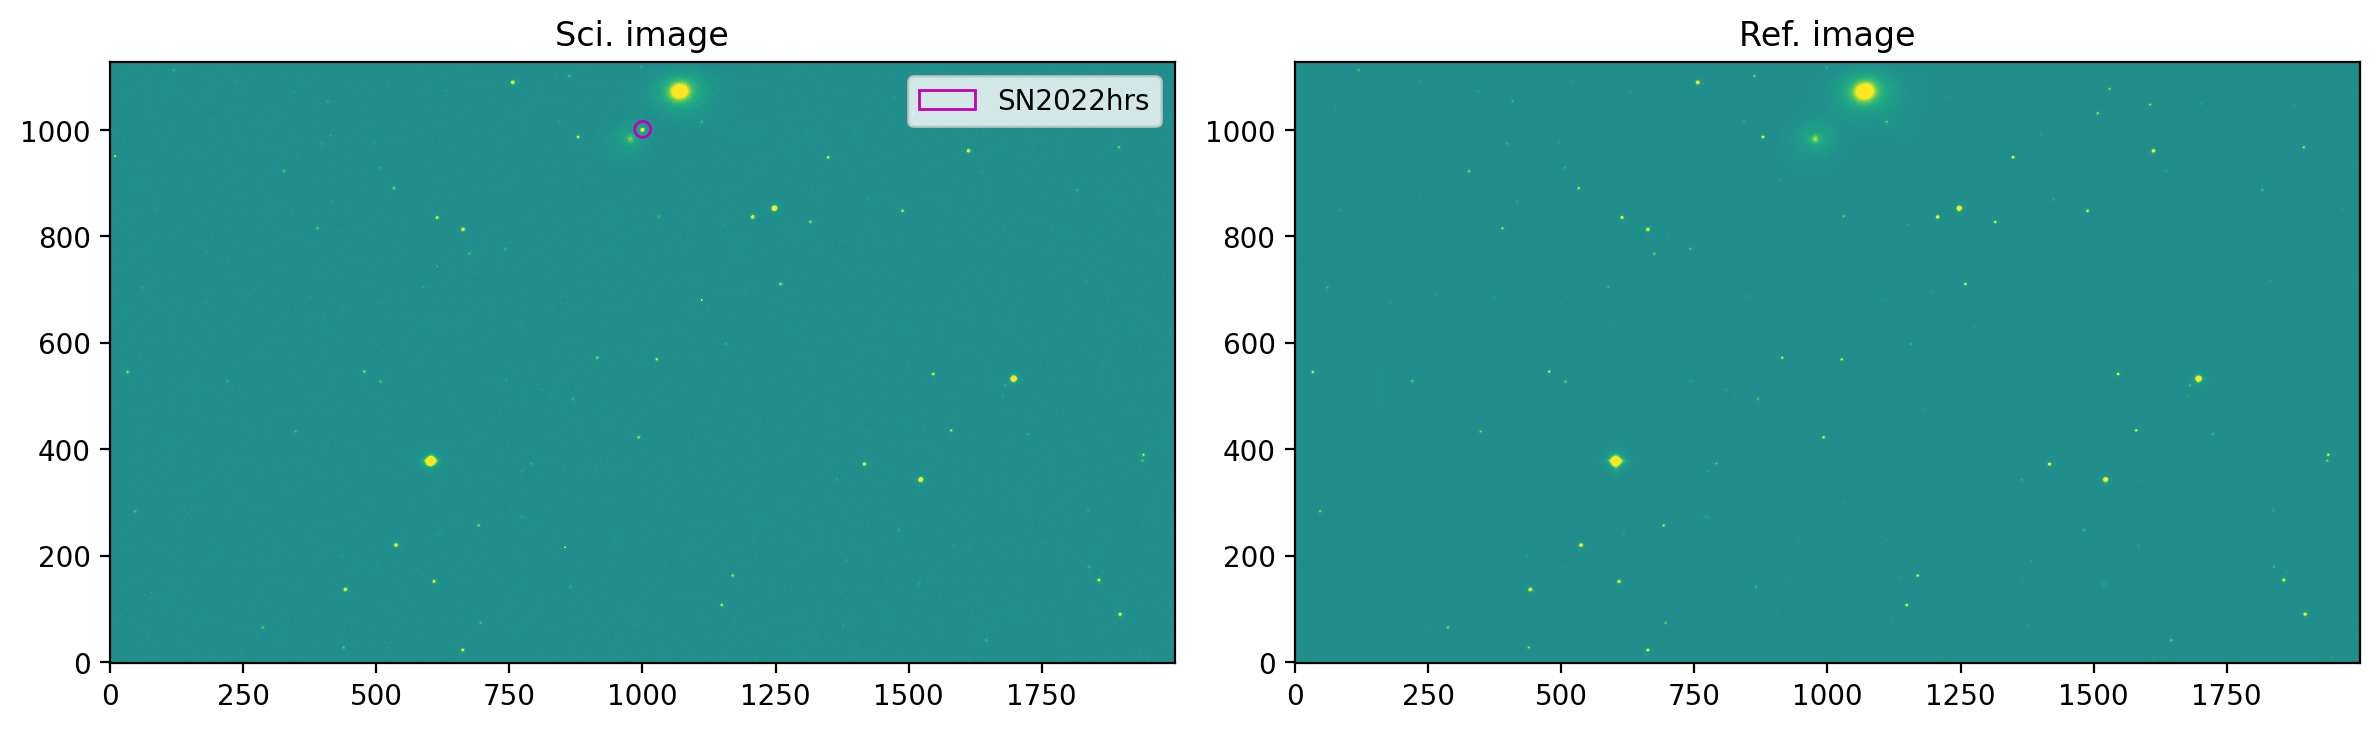

In [7]:
# Show image
nrow=1
ncol=2
fig, axes = plt.subplots(nrow, ncol, figsize=(12,8))
axes[0].imshow(data_sci_bkgsub, vmin=mean_sci-3*std_sci, vmax=mean_sci+3*std_sci, origin='lower')
axes[0].set_title('Sci. image')
c = patches.Circle(xy=(x_pix, y_pix), radius=15, fill=False, ec='m', lw=1, label='SN2022hrs')
axes[0].add_patch(c)
axes[1].imshow(data_ref_bkgsub, vmin=mean_ref-3*std_ref, vmax=mean_ref+3*std_ref, origin='lower')
axes[1].set_title('Ref. image')
axes[0].legend()
plt.tight_layout()

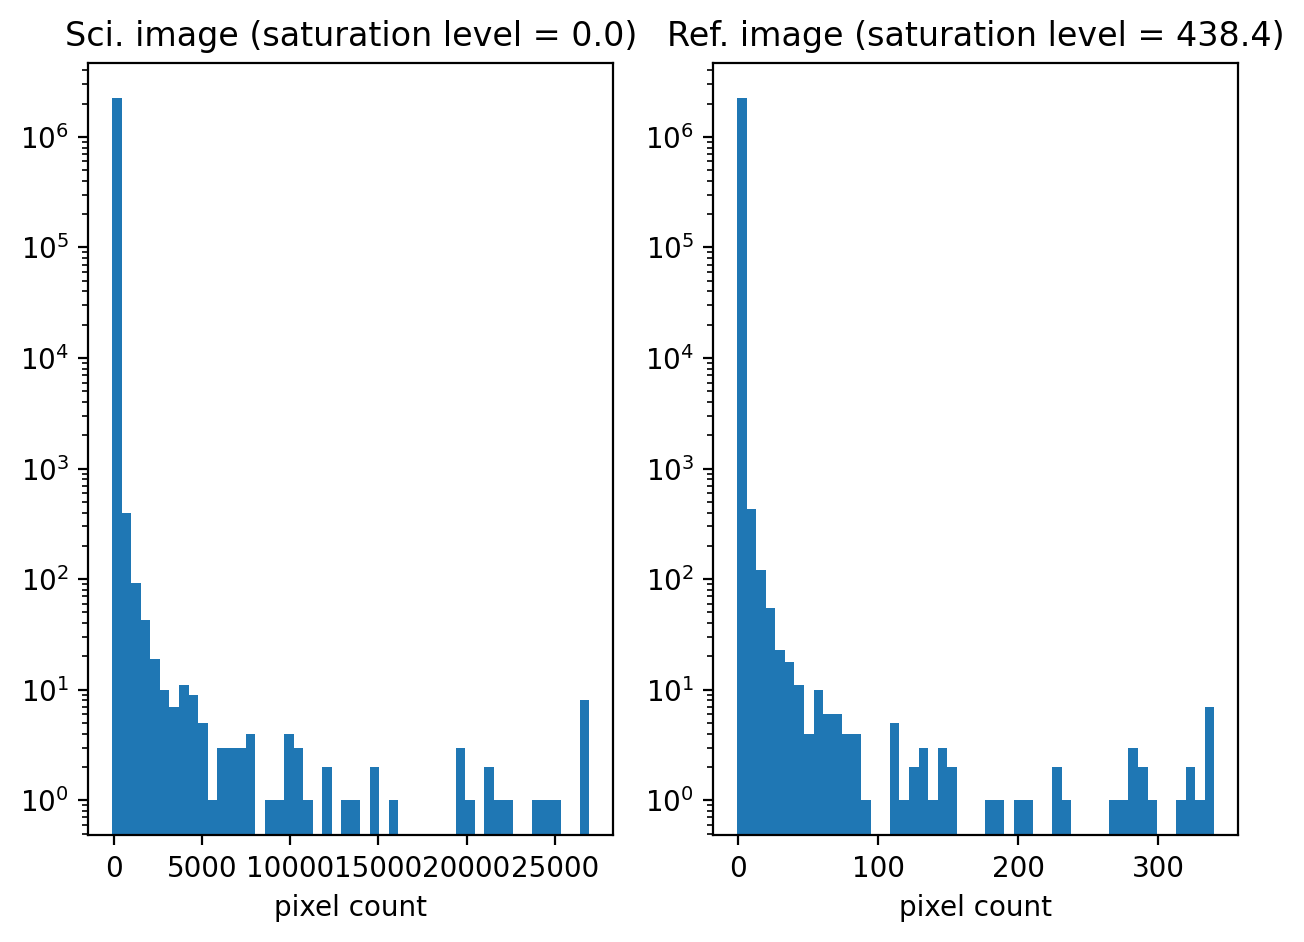

In [8]:
# Pixel count histogram
data1d_sci = data_sci_bkgsub.flatten()
data1d_ref = data_ref_bkgsub.flatten()
# Get saturation count
try:
    saturate_sci = header_sci['SATURATE']
except:
    saturate_sci = 0
try:
    saturate_ref = header_ref['SATURATE']
except:
    saturate_ref = 0
nrow=1
ncol=2
fig, axes = plt.subplots(nrow, ncol)
axes[0].hist(data1d_sci, bins=50, log=True)
axes[0].set_xlabel('pixel count')
axes[0].set_title('Sci. image (saturation level = {:.1f})'.format(saturate_sci))
axes[1].hist(data1d_ref, bins=50, log=True)
axes[1].set_title('Ref. image (saturation level = {:.1f})'.format(saturate_ref))
axes[1].set_xlabel('pixel count')
plt.tight_layout()

In [14]:
fits_diff = runhotpants(sci_img=fits_sci, ref_img=fits_ref, frame_num=11, out_dir=out_dir)

# of frames = 11


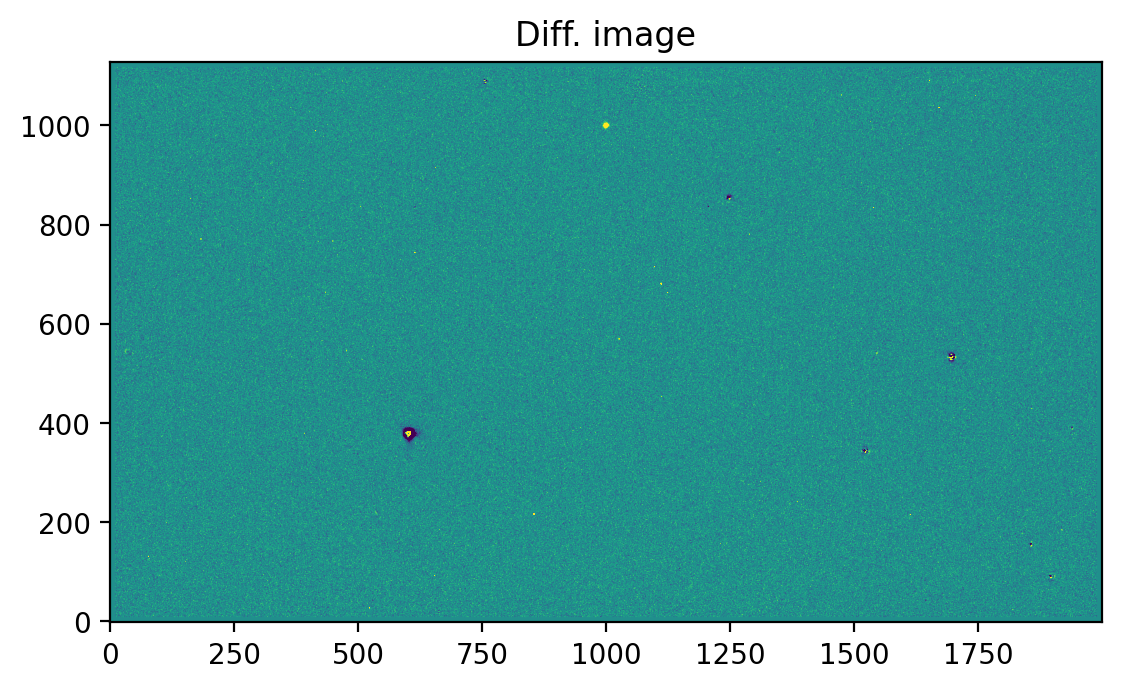

In [15]:
header_diff, data_diff = tomoeutils.openfits(fits_diff)
mean_diff = np.mean(data_diff)
std_diff = np.std(data_diff)
plt.title('Diff. image')
plt.imshow(data_diff, vmin=mean_diff-3*std_diff, vmax=mean_diff+3*std_diff, origin='lower')

In [16]:
# Make PSF model
data_psf, header_psf, df_psfstars = mkpsf_func.make_psfmodel(fits_sci, save_dir=out_dir, star_num=25, psfrad=7, fitrad=6)

### 58 PSF stars were found ###
### 25 PSF stars were used ###
STAR  X  Y  MAG  SKY
1 1247.241548354256 853.216400998399 [12.99151928] 0.14104278205176968

STAR  X  Y  MAG  SKY
2 1522.0352951210746 343.88717773783026 [13.41699318] -2.2329502687799416

STAR  X  Y  MAG  SKY
3 999.3837383315573 1000.2018719558979 [14.282211] 21.651847688367788

STAR  X  Y  MAG  SKY
4 755.975031641268 1089.4354369940781 [14.44160042] 2.34991852827645

STAR  X  Y  MAG  SKY
5 441.530627033592 137.58398542551976 [14.58646714] -1.0125373918596072

STAR  X  Y  MAG  SKY
6 662.345388728214 813.4389083021978 [14.57827166] 1.5575357305830275

STAR  X  Y  MAG  SKY
7 536.5790002719551 220.91626307593452 [14.57696707] -0.8635133692027824

STAR  X  Y  MAG  SKY
8 1611.7841525429737 960.8870457470565 [14.64056395] 0.01730132786573562

STAR  X  Y  MAG  SKY
9 1206.57992162463 836.664973518331 [14.63249485] 0.4364894006411877

STAR  X  Y  MAG  SKY
10 1896.532100897593 91.02708205121864 [14.81748682] -3.101192818763689

STAR

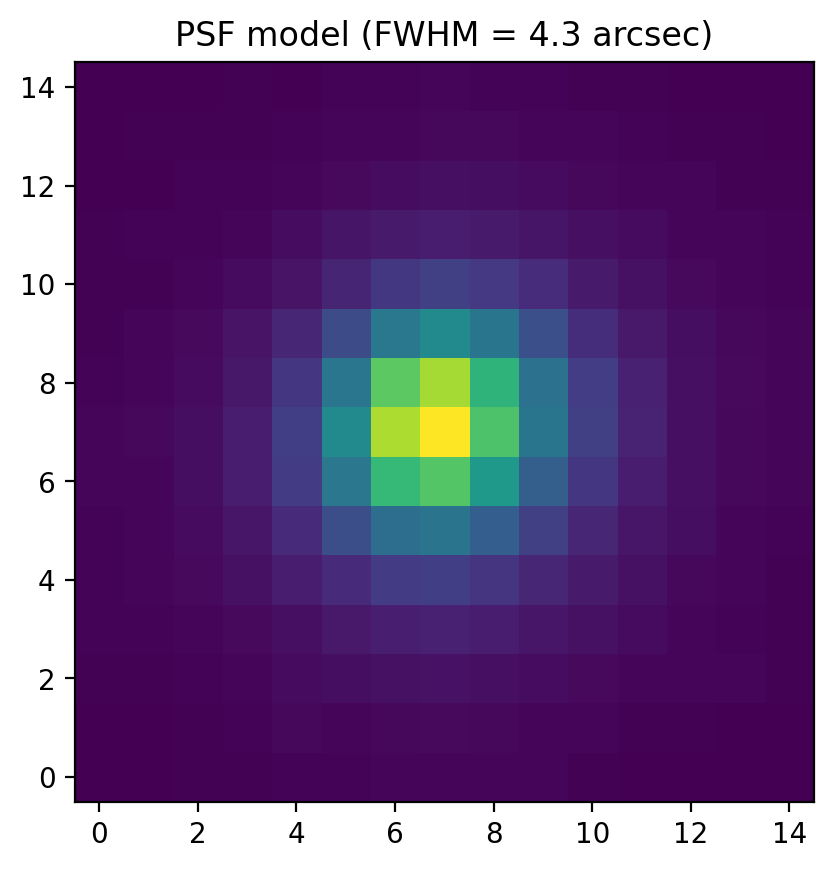

In [23]:
# Check PSF model image
sigma_x = header_psf['GAUSS4']
sigma_y = header_psf['GAUSS5']
fwhm_x = 2.0 * sigma_x * np.sqrt(2.0 * np.log(2)) * 1.19 
fwhm_y = 2.0 * sigma_y * np.sqrt(2.0 * np.log(2)) * 1.19
fwhm = (fwhm_x+fwhm_y)/2.0

mean_psf = np.mean(data_psf)
std_psf = np.std(data_psf)
plt.title('PSF model (FWHM = {:.1f} arcsec)'.format(fwhm))
plt.imshow(data_psf, origin='lower')
#plt.imshow(data_psf, vmin=mean_psf-3*std_psf, vmax=mean_psf+3*std_psf, origin='lower')

[[7.33540511e+07 1.10010036e+08 1.54410463e+08 2.05810738e+08
  2.59011705e+08 3.04726046e+08 3.33528447e+08 3.39076871e+08
  3.17880627e+08 2.74843897e+08 2.21201941e+08 1.68614193e+08
  1.24363511e+08 8.89459536e+07 5.92236412e+07]
 [1.14387673e+08 1.75352066e+08 2.50323424e+08 3.40421578e+08
  4.38840320e+08 5.28642961e+08 5.88438205e+08 6.01004706e+08
  5.60695851e+08 4.79850380e+08 3.81129529e+08 2.85533918e+08
  2.05707594e+08 1.43505572e+08 9.31969037e+07]
 [1.63714417e+08 2.57268110e+08 3.76087980e+08 5.25351121e+08
  6.97964732e+08 8.65832952e+08 9.84031811e+08 1.01166412e+09
  9.37264164e+08 7.88934926e+08 6.12826390e+08 4.47332835e+08
  3.12284784e+08 2.09913584e+08 1.31993168e+08]
 [2.17879526e+08 3.52264904e+08 5.32937537e+08 7.73711709e+08
  1.06976404e+09 1.37491419e+09 1.60111428e+09 1.65956673e+09
  1.52345887e+09 1.25273106e+09 9.42636656e+08 6.64552173e+08
  4.46953698e+08 2.88561925e+08 1.75220125e+08]
 [2.71241484e+08 4.51828309e+08 7.11040105e+08 1.08022747e+09
  

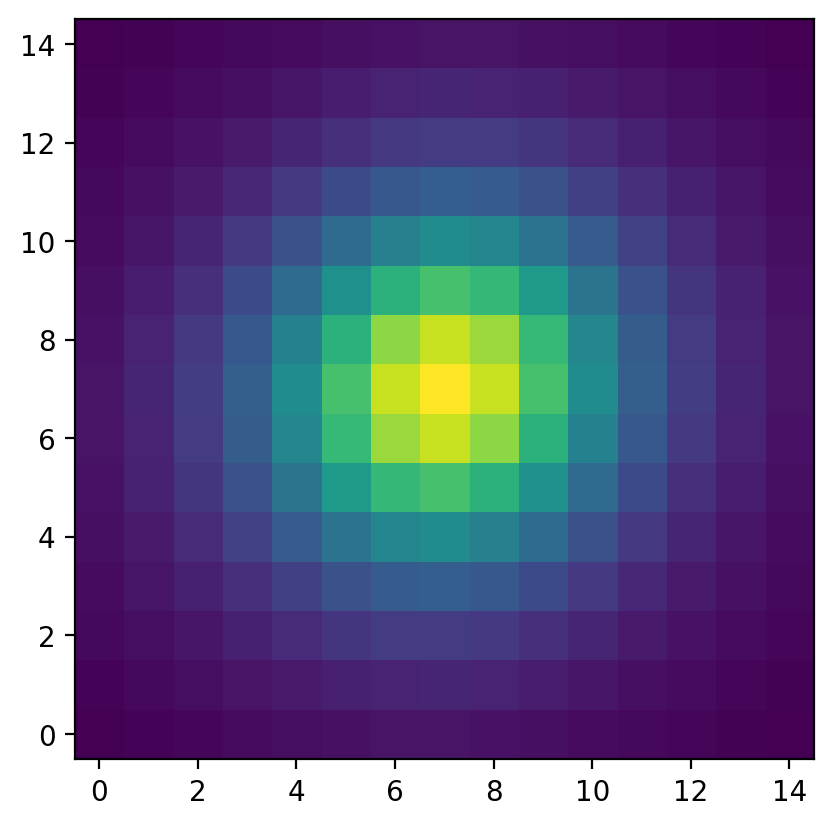

In [24]:
data_psf_rev = np.flip(data_psf.copy())
psf_conv = signal.convolve2d(data_psf, data_psf_rev, mode='same')
print(psf_conv)
plt.imshow(psf_conv, origin='lower')

In [13]:
# Run SEP on the difference image
thresh=5; minarea=1
df_obj, data_bkgsub, data_segmap, bkg_mean, bkg_rms = tomoeutils.detectobj(data_diff, thresh=thresh, minarea=minarea, filter_kernel=data_psf, use_segmap=True, radius1=5.0, radius2=7.0, gain=0.23)

In [45]:
# Run SEP without PSF model
thresh_nopsf=5; minarea_nopsf=10
df_obj_nopsf, data_bkgsub_nopsf, data_segmap_nopsf, bkg_mean_nopsf, bkg_rms_nopsf = tomoeutils.detectobj(data_diff, thresh=thresh_nopsf, minarea=minarea_nopsf, filter_kernel=None, use_segmap=True, radius1=5.0, radius2=7.0, gain=0.23)

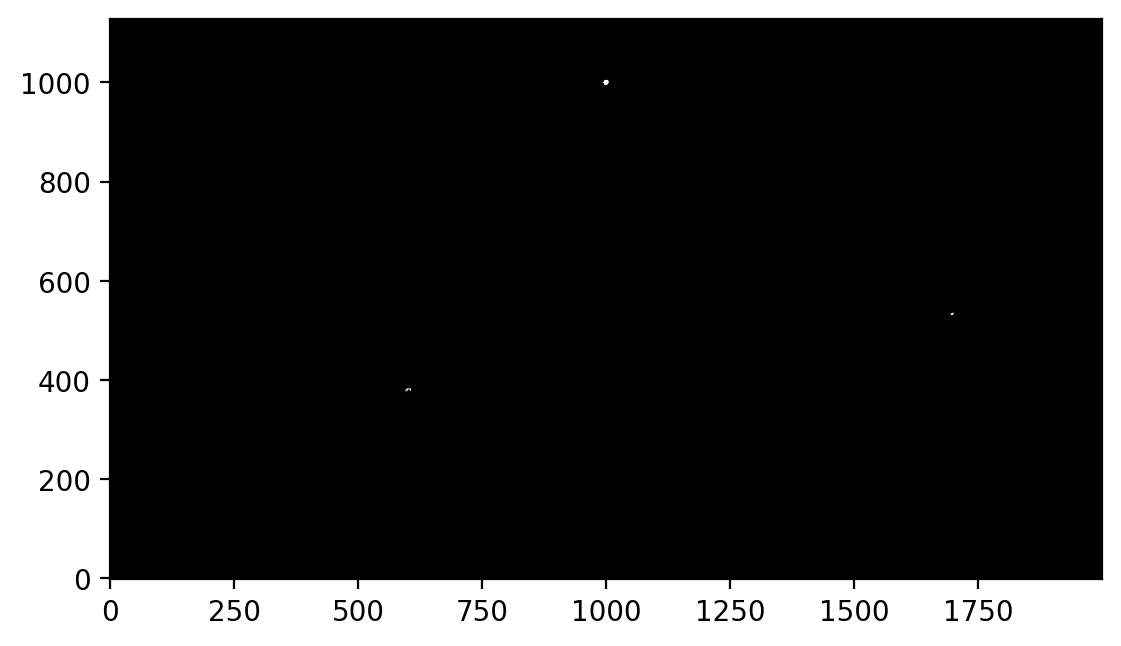

In [46]:
plt.imshow(data_segmap_nopsf, origin='lower', vmin=0, vmax=1, cmap='gray')

In [47]:
df_obj_nopsf

thresh  npix  tnpix  xmin  xmax  ymin  ymax            x            y  \
0  0.926925    39     39   595   606   377   383   602.024428   381.825421   
1  0.926925    12     12  1695  1700   532   535  1697.067077   532.713766   
2  0.926925    66     66   994  1004   996  1004   999.395840  1000.191518   

         x2        y2        xy     errx2     erry2     errxy         a  \
0  5.302438  1.494459  0.309828  0.000068  0.000015  0.000013  2.308134   
1  1.201535  0.775875  0.566228  0.000276  0.000185  0.000157  1.262383   
2  3.059375  2.898826  0.137817  0.000175  0.000158  0.000005  1.771607   

          b     theta       cxx       cyy       cxy       cflux        flux  \
0  1.212195  0.080656  0.190905  0.677344 -0.079156  520.927917  520.927917   
1  0.619515  0.605630  1.268544  1.964491 -1.851549   57.284916   57.284916   
2  1.679169  0.521683  0.327566  0.345708 -0.031147  272.151733  272.151733   

       cpeak       peak  xcpeak  ycpeak  xpeak  ypeak  flag  ap1flux_5pix  \
0  47.803249  47.803249     600     381    600    381     1    451.666037   
1  10.491302  10.491302    1697     532   1697    532     1    -10.963459   
2  15.454843  15.454843     999    1000    999   1000     0    279.852967   

   ap1ferr_5pix  ap1_flag  ap2flux_7pix  ap2ferr_7pix  ap2_flag      reff  
0     44.344799         0    415.793661     42.580327         0  1.882406  
1      1.645234         0    -27.619182      2.302957         0  0.000000  
2     34.920455         0    308.865089     36.717592         0  2.120687

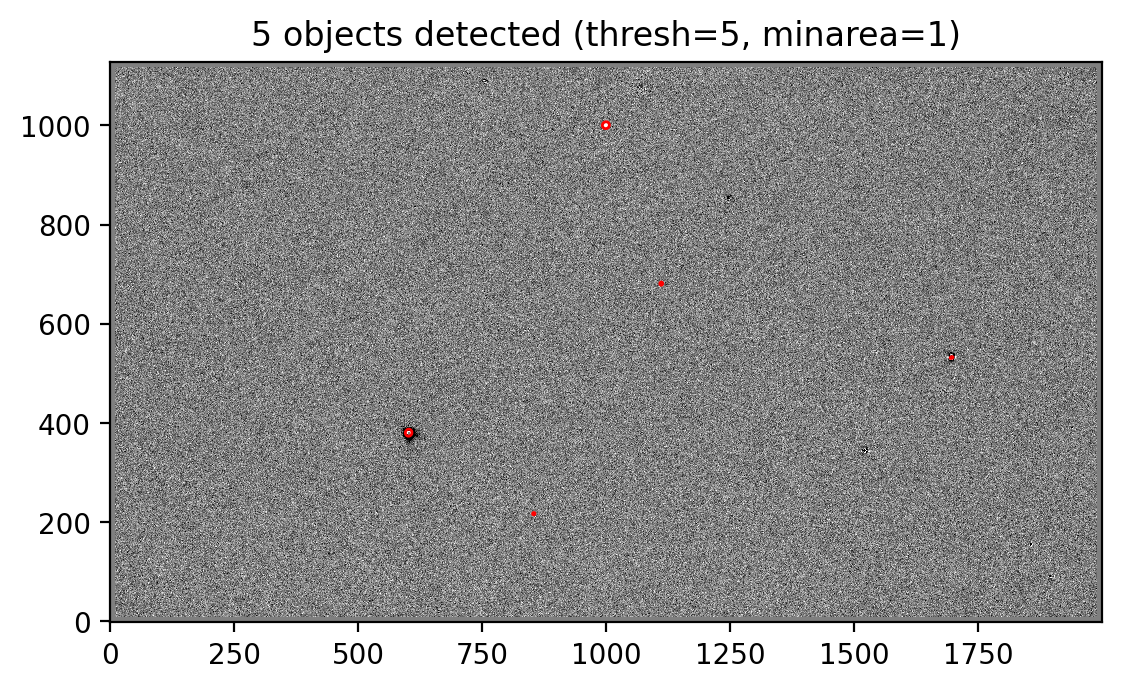

In [14]:
# Show detected objects on the difference image

fig, ax = plt.subplots()
ax.set_title('{0} objects detected (thresh={1}, minarea={2})'.format(len(df_obj), thresh, minarea))
im = ax.imshow(data_diff, interpolation='nearest', cmap='gray', \
               vmin=mean_diff-3*std_diff, vmax=mean_diff+3*std_diff, origin='lower')
# plot an ellipse for each object
for i in range(len(df_obj)):
    e = Ellipse(xy=(df_obj['x'][i], df_obj['y'][i]),
                width=6*df_obj['a'][i],
                height=6*df_obj['b'][i],
                angle=df_obj['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [34]:
# Save segmap as a FITS file
segmap_savename = out_dir + '/' + fits_sci_basename + '_segmap.fits'
# save as npy
#np.save(segmap_savename + '.npy', self.segmap_stack)
# save as FITS
segmap_header = header_sci
segmap_header['HISTORY'] = 'This is a segmentation map created by SEP'
segmap_header['THRESH'] = (thresh, 'SEP thresh parameter')
segmap_header['MINAREA'] = (minarea, 'SEP minarea parameter')
segmap_header['OBJNUM'] = len(df_obj), 'The number of detected objects'
data_segmap = fits.PrimaryHDU(data_segmap, segmap_header)
# data_segmap.writeto(segmap_savename, overwrite=True)

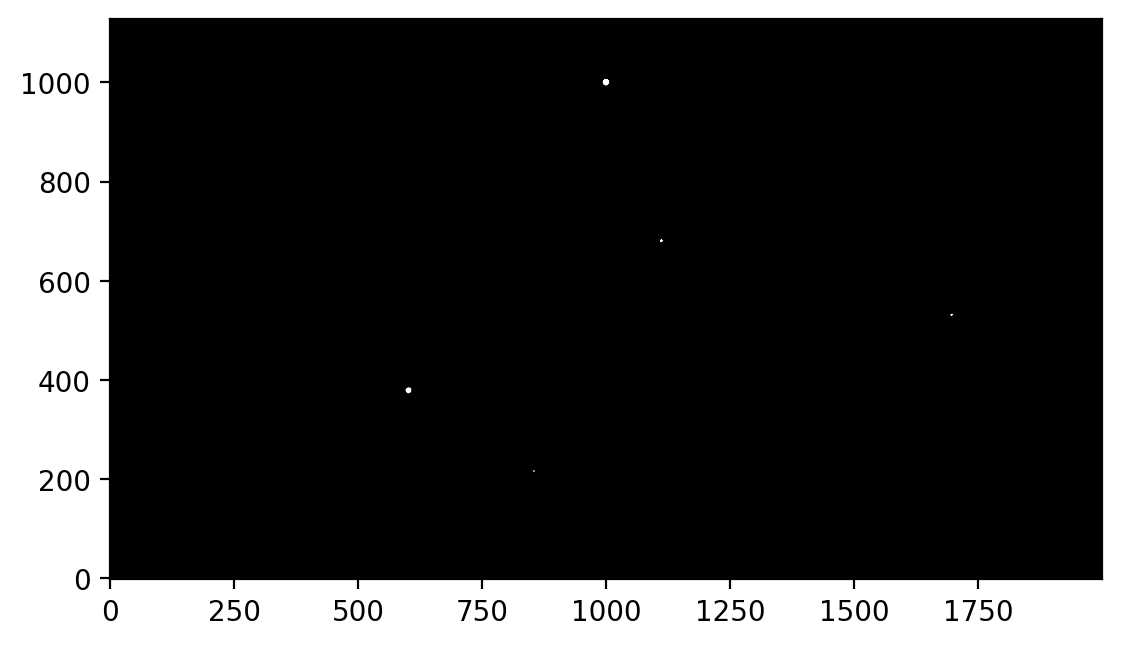

In [15]:
plt.imshow(data_segmap, origin='lower', vmin=0, vmax=1, cmap='gray')

In [16]:
df_obj

thresh  npix  tnpix  xmin  xmax  ymin  ymax            x            y  \
0  0.926925     9      1   853   855   216   218   854.054084   216.954373   
1  0.926925    91     47   596   606   374   385   601.718338   380.254122   
2  0.926925     8      5  1695  1698   531   533  1696.373300   531.758446   
3  0.926925    15      3  1109  1113   679   683  1111.047493   680.775079   
4  0.926925    99     66   994  1005   995  1005   999.377786  1000.190965   

         x2        y2        xy     errx2     erry2     errxy         a  \
0  0.614285  0.615021  0.009512  0.001339  0.001338 -0.000005  0.790046   
1  5.016548  5.504177  0.232725  0.000125  0.000131  0.000010  2.365886   
2  0.892677  0.413430  0.201354  0.003090  0.001374  0.000687  0.982875   
3  0.901908  1.137608  0.013726  0.001173  0.001533  0.000002  1.066960   
4  5.499220  5.313006  0.281375  0.000439  0.000417  0.000019  2.387989   

          b     theta       cxx       cyy       cxy       cflux        flux  \
0  0.777903  0.804754  1.628300  1.626349 -0.050369   12.435052   36.636726   
1  2.218853  1.189730  0.199732  0.182037 -0.016890  428.508911  645.894226   
2  0.583150  0.349415  1.258477  2.717298 -1.225836    9.358258   34.260124   
3  0.949269  1.512821  1.108965  0.879199 -0.026761   21.675323   46.610134   
4  2.260472  0.625619  0.182338  0.188729 -0.019313  250.370911  293.229614   

       cpeak       peak  xcpeak  ycpeak  xpeak  ypeak  flag  ap1flux_5pix  \
0   1.836418  36.596970     854     217    854    217     0     35.911248   
1  11.926785  47.803249     602     382    600    381     0    644.239683   
2   1.495100  10.491302    1697     532   1697    532     0      8.411483   
3   2.276731  40.698757    1111     681   1111    681     0     47.110179   
4   6.301461  15.454843     999    1000    999   1000     0    280.110581   

   ap1ferr_5pix  ap1_flag  ap2flux_7pix  ap2ferr_7pix  ap2_flag      reff  
0     12.603061         0     36.051750     12.729252         0  0.393772  
1     52.950399         0    435.920237     43.595896         0  2.951997  
2      6.266814         0    -29.533584      2.299970         0  0.413181  
3     14.405790         0     48.845261     14.753464         0  0.455726  
4     34.936666         0    308.797217     36.713498         0  2.119073

In [17]:
df_obj.loc[:, 'peak_sqrt_npix'] = df_obj['peak'] / np.sqrt(df_obj['npix'])

In [18]:
df_obj.loc[:, 'ellip'] = (df_obj['a'] - df_obj['b']) / df_obj['a']

In [19]:
df_obj

thresh  npix  tnpix  xmin  xmax  ymin  ymax            x            y  \
0  0.926925     9      1   853   855   216   218   854.054084   216.954373   
1  0.926925    91     47   596   606   374   385   601.718338   380.254122   
2  0.926925     8      5  1695  1698   531   533  1696.373300   531.758446   
3  0.926925    15      3  1109  1113   679   683  1111.047493   680.775079   
4  0.926925    99     66   994  1005   995  1005   999.377786  1000.190965   

         x2        y2        xy     errx2     erry2     errxy         a  \
0  0.614285  0.615021  0.009512  0.001339  0.001338 -0.000005  0.790046   
1  5.016548  5.504177  0.232725  0.000125  0.000131  0.000010  2.365886   
2  0.892677  0.413430  0.201354  0.003090  0.001374  0.000687  0.982875   
3  0.901908  1.137608  0.013726  0.001173  0.001533  0.000002  1.066960   
4  5.499220  5.313006  0.281375  0.000439  0.000417  0.000019  2.387989   

          b     theta       cxx       cyy       cxy       cflux        flux  \
0  0.777903  0.804754  1.628300  1.626349 -0.050369   12.435052   36.636726   
1  2.218853  1.189730  0.199732  0.182037 -0.016890  428.508911  645.894226   
2  0.583150  0.349415  1.258477  2.717298 -1.225836    9.358258   34.260124   
3  0.949269  1.512821  1.108965  0.879199 -0.026761   21.675323   46.610134   
4  2.260472  0.625619  0.182338  0.188729 -0.019313  250.370911  293.229614   

       cpeak       peak  xcpeak  ycpeak  xpeak  ypeak  flag  ap1flux_5pix  \
0   1.836418  36.596970     854     217    854    217     0     35.911248   
1  11.926785  47.803249     602     382    600    381     0    644.239683   
2   1.495100  10.491302    1697     532   1697    532     0      8.411483   
3   2.276731  40.698757    1111     681   1111    681     0     47.110179   
4   6.301461  15.454843     999    1000    999   1000     0    280.110581   

   ap1ferr_5pix  ap1_flag  ap2flux_7pix  ap2ferr_7pix  ap2_flag      reff  \
0     12.603061         0     36.051750     12.729252         0  0.393772   
1     52.950399         0    435.920237     43.595896         0  2.951997   
2      6.266814         0    -29.533584      2.299970         0  0.413181   
3     14.405790         0     48.845261     14.753464         0  0.455726   
4     34.936666         0    308.797217     36.713498         0  2.119073   

   peak_sqrt_npix     ellip  
0       12.198990  0.015369  
1        5.011142  0.062147  
2        3.709235  0.406690  
3       10.508374  0.110306  
4        1.553270  0.053400

<AxesSubplot:xlabel='cpeak', ylabel='peak_sqrt_npix'>

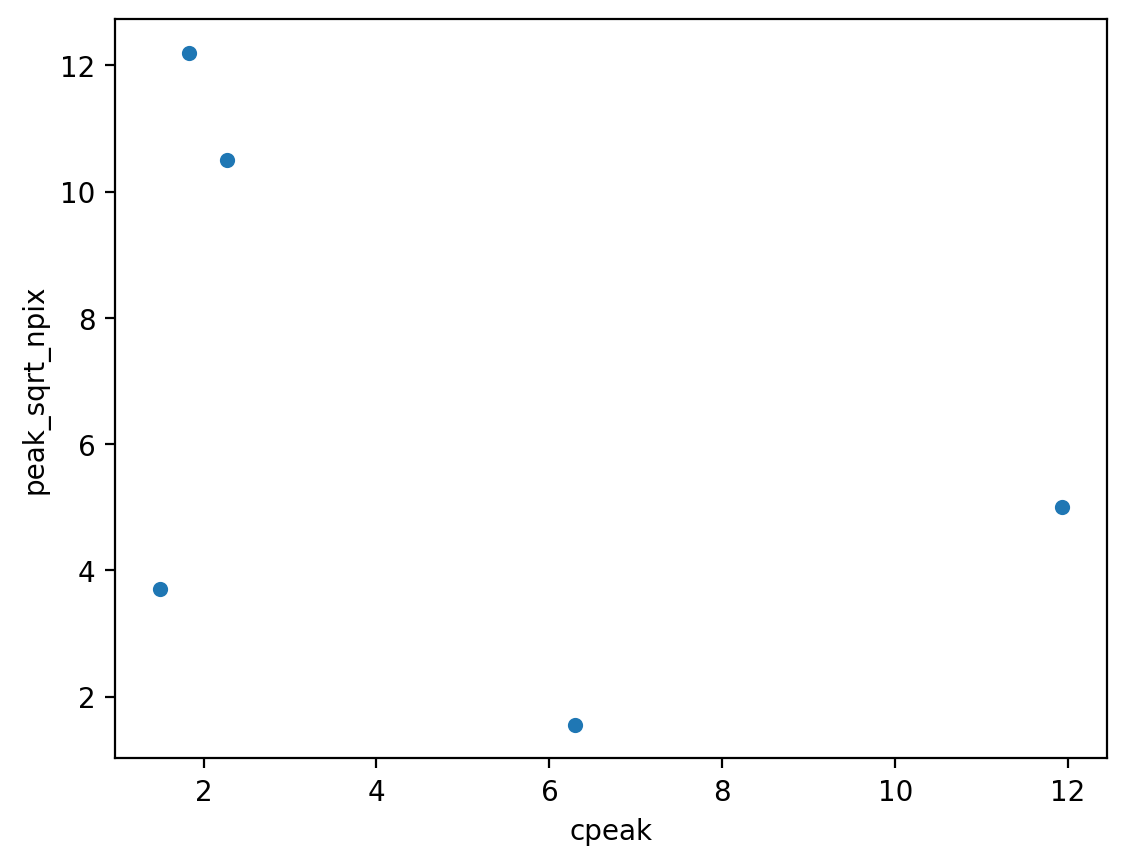

In [20]:
df_obj.plot(x='cpeak', y='peak_sqrt_npix', kind='scatter')

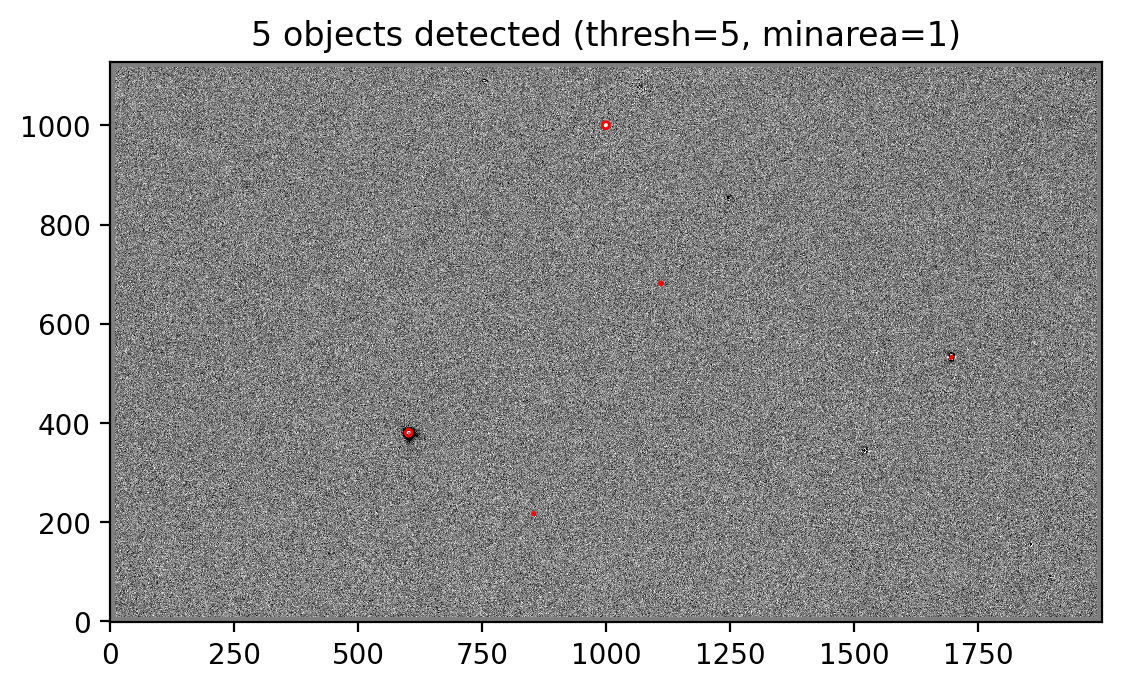

In [21]:
# 
# Reverse the order of elements in the PSF array (using np.flip)
data_psf_flip = np.flip(data_psf)
# Run SEP on the difference image
df_obj_flip, data_bkgsub_flip, data_segmap_flip, bkg_mean_flip, bkg_rms_flip = tomoeutils.detectobj(data_diff, thresh=thresh, minarea=minarea, filter_kernel=data_psf_flip, use_segmap=True, radius1=5.0, radius2=7.0, gain=0.23)

# Show detected objects on the difference image

fig, ax = plt.subplots()
ax.set_title('{0} objects detected (thresh={1}, minarea={2})'.format(len(df_obj_flip), thresh, minarea))
im = ax.imshow(data_diff, interpolation='nearest', cmap='gray', \
               vmin=mean_diff-3*std_diff, vmax=mean_diff+3*std_diff, origin='lower')
# plot an ellipse for each object
for i in range(len(df_obj_flip)):
    e = Ellipse(xy=(df_obj_flip['x'][i], df_obj_flip['y'][i]),
                width=6*df_obj_flip['a'][i],
                height=6*df_obj_flip['b'][i],
                angle=df_obj_flip['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

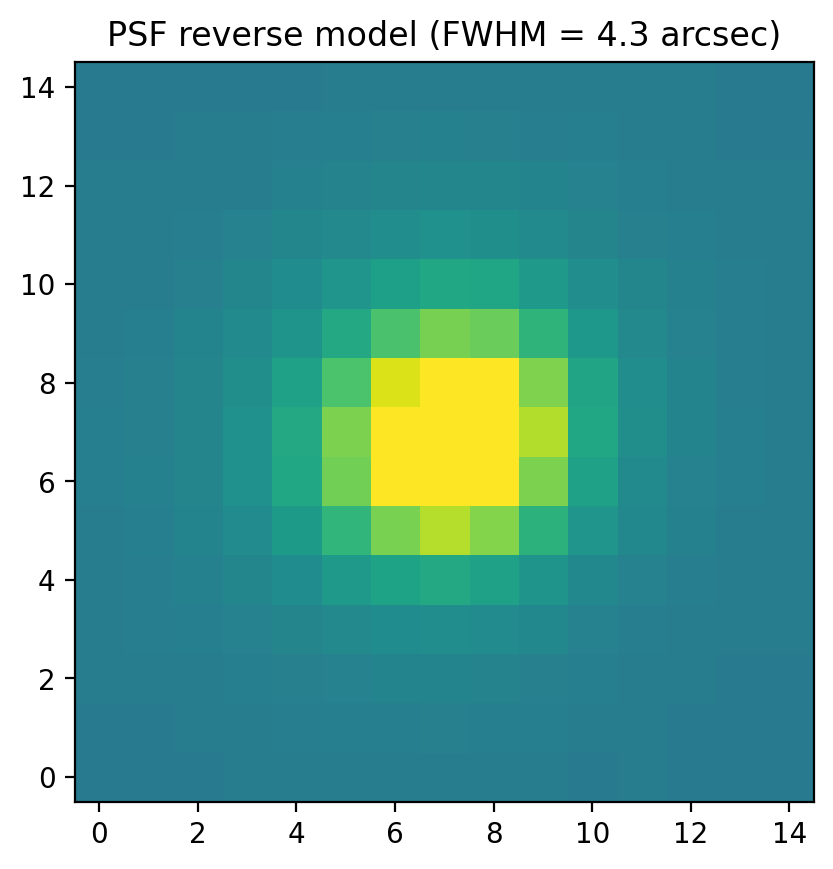

In [22]:
# Reverse the order of elements in the PSF array
plt.title('PSF reverse model (FWHM = {:.1f} arcsec)'.format(fwhm))
plt.imshow(data_psf_flip, vmin=mean_psf-3*std_psf, vmax=mean_psf+3*std_psf, origin='lower')

In [37]:
# Make mask array for SEP object detection
mask_arr = np.where(data_diff.copy() < 0.001, 1, 0)
mask_arr


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [36]:
np.histogram(mask_arr)

(array([ 654900,       0,       0,       0,       0,       0,       0,
              0,       0, 1601100]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

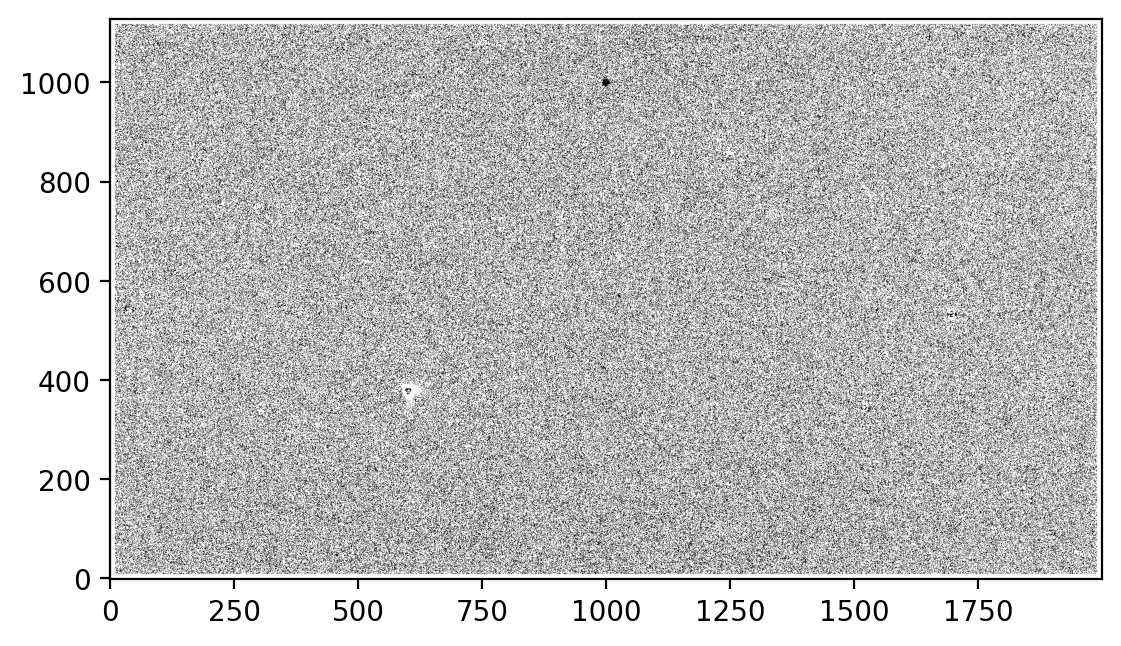

In [35]:
plt.imshow(mask_arr, origin='lower', vmin=0, vmax=1, cmap='gray')

In [24]:
np.where(mask_arr==False)

(array([  10,   10,   10, ..., 1117, 1117, 1117]),
 array([  10,   12,   17, ..., 1984, 1987, 1988]))

In [27]:
df_obj, data_bkgsub, data_segmap, bkg_mean, bkg_rms = tomoeutils.detectobj(data_diff, thresh=thresh, minarea=minarea, filter_kernel=data_psf, use_segmap=True, radius1=5.0, radius2=7.0, gain=0.23, mask=mask_arr)

In [28]:
df_obj

thresh  npix  tnpix  xmin  xmax  ymin  ymax            x            y  \
0  0.926925    10      1   853   855   215   218   854.048920   216.827602   
1  0.926925   157     54   595   608   373   387   601.869023   380.253646   
2  0.926925    33     15  1693  1699   529   535  1696.177556   532.258850   
3  0.926925    18      3  1109  1113   679   683  1111.122027   680.758710   
4  0.926925    99     66   994  1005   995  1005   999.378078  1000.190749   

         x2        y2        xy     errx2     erry2     errxy         a  \
0  0.576306  0.814279  0.013400  0.001054  0.001681  0.000002  0.902791   
1  7.298706  8.946374  0.328417  0.000147  0.000174  0.000008  3.001570   
2  2.806959  1.939351  0.535325  0.001628  0.001202  0.000336  1.749909   
3  1.249630  1.118038  0.104202  0.001493  0.001270  0.000138  1.143272   
4  5.512265  5.323060  0.280138  0.000437  0.000415  0.000019  2.390260   

          b     theta       cxx       cyy       cxy       cflux        flux  \
0  0.758652  1.514724  1.735855  1.228550 -0.057132   14.013853   37.137753   
1  2.689918  1.381128  0.137237  0.111962 -0.010076  651.814514  715.649231   
2  1.297740  0.444886  0.376054  0.544289 -0.207607   47.239216   70.661446   
3  1.029853  0.503793  0.806504  0.901430 -0.150334   25.289307   47.328354   
4  2.263180  0.622560  0.181900  0.188366 -0.019146  250.945023  293.229614   

       cpeak       peak  xcpeak  ycpeak  xpeak  ypeak  flag  ap1flux_5pix  \
0   1.906868  36.596970     854     217    854    217     0     35.833659   
1  12.835825  47.803249     602     382    600    381     0    640.375835   
2   2.322073  10.491302    1697     532   1697    532     0      6.693428   
3   2.316570  40.698757    1111     681   1111    681     0     47.106676   
4   6.302540  15.454843     999    1000    999   1000     0    280.110581   

   ap1ferr_5pix  ap1_flag  ap2flux_7pix  ap2ferr_7pix  ap2_flag      reff  
0     12.589616         0     35.933259     12.709270         0  0.393379  
1     52.791502         0    430.477591     43.323616         0  2.916360  
2      5.639185         0    -28.385045      2.300269         0  0.362378  
3     14.405166         0     48.710521     14.733596         0  0.489514  
4     34.936666         0    308.797217     36.713498         0  2.117972

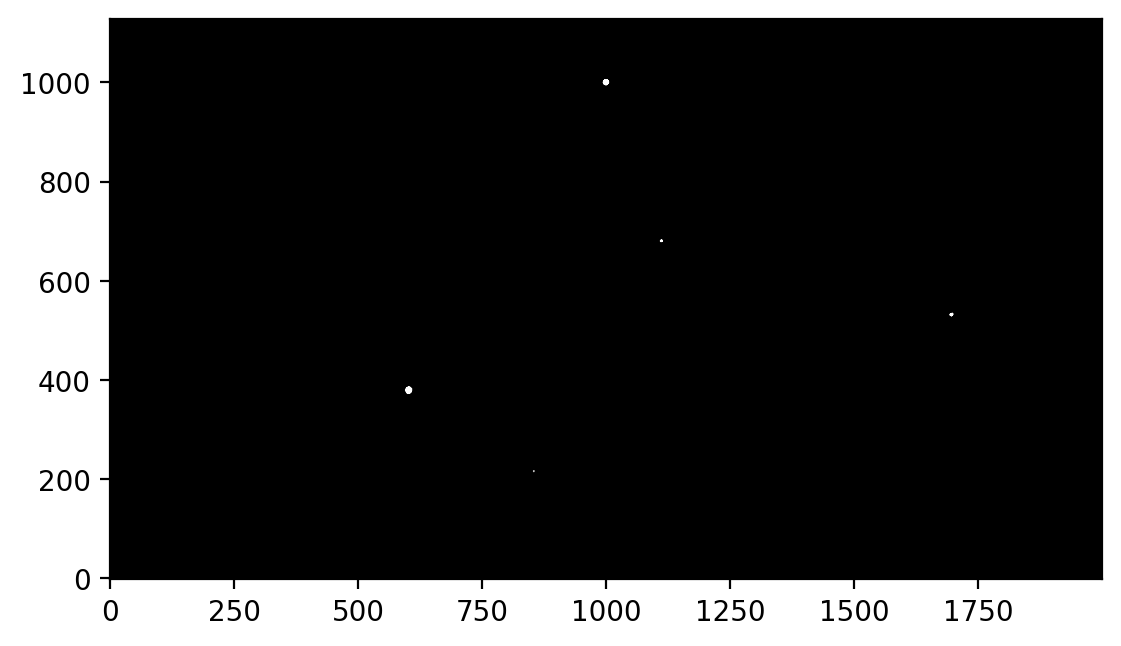

In [29]:
plt.imshow(data_segmap, origin='lower', vmin=0, vmax=1, cmap='gray')